In [23]:
# imports and loadings
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statistics
from sympy import *
import sys
sys.path.append('../promoter_solving/')
from promoter_solving_core import *
from deap import algorithms, base, creator, tools
import random
from scipy.stats import spearmanr

# settings
input_parameters = {
    # base condition for mRNA ratio generation parameters
    'gene_of_interest' : 'b2143', 
    'basal_conditions' : ['control__wt_glc__1', 'control__wt_glc__2'],
    'use_zerod_A_matrix' : True, # recalculate the ICA matrices based on zeroing out gene values in iModulons not of interest
    'control_value_log_tpm' : 10, # basal log tpm value hard set for now
    'grid_use' : -1, # which of the generated constants grids do you want to use? -1 is the highest KdRNAP
    
    
    # cActivator/cInhibitor genetic algorithm paramters
    'nind' : 100,
    'mu' : 50,
    'lambda_' : 100,
    'cxpb' : 0.7,
    'mutpb' : 0.3,
    'ngen' : 100,
}

if True: # just to condense this as you don't need to change it often
    # set some of these inputs to variable names used in the code
    basal_conditions = input_parameters['basal_conditions']
    use_zerod_A_matrix = input_parameters['use_zerod_A_matrix']
    gene = input_parameters['gene_of_interest']
    control_value_log_tpm = input_parameters['control_value_log_tpm']
    grid_use = input_parameters['grid_use']

    # Notes
    # 1 - this is only currently set up for one activator and one inhibitor models

    # setup
    gene_to_act_inh_iMs = {
        'b1101' : ['Crp-2', 'DhaR/Mlc'],
        'b1817' : ['Crp-2', 'DhaR/Mlc'],
        'b1818' : ['Crp-2', 'DhaR/Mlc'],
        'b1819' : ['Crp-2', 'DhaR/Mlc'],
        'b2151' : ['Crp-1', 'Crp-2'],
        'b3601' : ['Crp-1', 'Crp-2'],
        'b2239' : ['Crp-2', 'GlpR'],
        'b2240' : ['Crp-2', 'GlpR'],
        'b0723' : ['Crp-2', 'ArcA-1'],
        'b1415' : ['Crp-2', 'Crp-1'],
        'b2597' : ['Crp-2', 'CpxR'],
        'b3403' : ['Crp-2', 'crp-KO'],
        'b4267' : ['Crp-2', 'GntR/TyrR'],
        'b2143' : ['Crp-2', 'YieP'],
    }
    iM_act = gene_to_act_inh_iMs[gene][0]
    iM_inh = gene_to_act_inh_iMs[gene][1]

    # loading
    A_df = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0)
    iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
    A_df = A_df.rename(index = {index : row['name'] for index, row in iM_table.iterrows()})

    M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
    M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

    log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
    A_df = A_df[log_tpm_df.columns]

    # function definition
    if True:
        def cActivator_cInhibitor_to_mRNA(cActivator, cInhibitor, RNAP = 1, KdRNAP = 1, KdRNAPCrp = 1, KeqOpening = 1):
            mRNA = ((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
                    KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
                    cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
                    KeqOpening)*RNAP)

            return(mRNA)

        def log_tpm_to_mRNA_conc(val):
            mRNA = (2**val)*(10**-6)*1800/cell_volume/(6.022*(10**23))
            return(mRNA)

# mRNA ratio calculations

In [24]:
# creates zerod matrices
if use_zerod_A_matrix:
    gene_iMs_df = pd.read_csv('../data/precise_1.0/gene_presence_matrix.csv', index_col = 0)
    gene_iMs_df.columns = M_df.columns
    genes_to_zero = list(gene_iMs_df.index[[val for val in gene_iMs_df[[iM_act, iM_inh]].T.any()]])
    iMs_to_zero = list(set(gene_iMs_df.columns) - set([iM_act, iM_inh]))

    zerod_M = M_df.copy()
    zerod_M.loc[genes_to_zero, iMs_to_zero] = 0
    #zerod_M = zerod_M.drop(columns = ['fps__fps_ptsI_ale3__1', 'fps__fps_ptsI_ale3__2', 'fps__fps_ptsI_ale1__1', 'fps__fps_ptsI_ale1__2'])

    # Calculate the inverse of DataFrame M
    M_inverse = pd.DataFrame(np.linalg.pinv(zerod_M.values), zerod_M.columns, zerod_M.index)

    # Solve for DataFrame A: A = M_inverse * X
    #fixed_X = log_tpm_df.div(log_tpm_df[basal_conditions].mean(axis = 1), axis = 'index')
    fixed_X = log_tpm_df.sub(log_tpm_df[basal_conditions].mean(axis = 1), axis = 'index')
    fixed_X = fixed_X.fillna(0).drop(columns = ['fps__fps_ptsI_ale3__1', 'fps__fps_ptsI_ale3__2', 'fps__fps_ptsI_ale1__1', 'fps__fps_ptsI_ale1__2'])
    zerod_A_df = M_inverse.dot(fixed_X)
    
    A_df = zerod_A_df
    M_df = zerod_M

In [25]:
# create data matrix

# crp is the activator
act_MAs = []
inh_MAs = []
index = []
actual_counts = []
log_x_c = log_tpm_df.loc[gene][basal_conditions].mean()
# predict mRNA values
for key, val in (A_df.loc[iM_act].T*(M_df[iM_act].loc[gene])).items():
    index.append(key)
    act_MAs.append(val)
    actual_counts.append(2**(log_tpm_df.loc[gene][key]) / 2**(control_value_log_tpm))
for key, val in (A_df.loc[iM_inh].T*(M_df[iM_inh].loc[gene])).items():
    inh_MAs.append(val)
    
values_df = pd.DataFrame(index = index)
values_df['MA_activator'] = act_MAs
values_df['MA_inhibitor'] = inh_MAs
values_df['actual_mRNA_ratio'] = actual_counts

if use_zerod_A_matrix:
    values_df.to_pickle('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.pkl')
    values_df.to_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv')
else:
    values_df.to_pickle('../data/pickle_dfs/MA_for_activator_inhibitor_and_mRNA_ratios_df.pkl')
    values_df.to_csv('../data/pickle_dfs/MA_for_activator_inhibitor_and_mRNA_ratios_df.csv')
    


# crp is the activator
act_MAs = []
inh_MAs = []
index = []
actual_counts = []
log_x_c = log_tpm_df.loc[gene][basal_conditions].mean()
# predict mRNA values
for key, val in (A_df.loc[iM_act].T*(M_df[iM_act].loc[gene])).items():
    index.append(key)
    act_MAs.append(val)
    actual_counts.append(2**(log_tpm_df.loc[gene][key]) / 2**(control_value_log_tpm))
for key, val in (A_df.loc[iM_inh].T*(M_df[iM_inh].loc[gene])).items():
    inh_MAs.append(val)
    
values_df = pd.DataFrame(index = index)
values_df['MA_activator'] = act_MAs
values_df['MA_inhibitor'] = inh_MAs
values_df['actual_mRNA_ratio'] = actual_counts

if use_zerod_A_matrix:
    values_df.to_pickle('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.pkl')
    values_df.to_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv')
else:
    values_df.to_pickle('../data/pickle_dfs/MA_for_activator_inhibitor_and_mRNA_ratios_df.pkl')
    values_df.to_csv('../data/pickle_dfs/MA_for_activator_inhibitor_and_mRNA_ratios_df.csv')

In [12]:
# create data matrix loop through genes to make all
if True:
    
    for g in ['b2143']:#['b1101', 'b1817', 'b2239', 'b0723', 'b2597']:
        # crp is the activator
        act_MAs = []
        inh_MAs = []
        index = []
        actual_counts = []
        log_x_c = log_tpm_df.loc[g][basal_conditions].mean()
        # predict mRNA values
        for key, val in (A_df.loc[iM_act].T*(M_df[iM_act].loc[g])).items():
            index.append(key)
            act_MAs.append(val)
            actual_counts.append(2**(log_tpm_df.loc[g][key]) / 2**(control_value_log_tpm))
        for key, val in (A_df.loc[iM_inh].T*(M_df[iM_inh].loc[g])).items():
            inh_MAs.append(val)

        values_df = pd.DataFrame(index = index)
        values_df['MA_activator'] = act_MAs
        values_df['MA_inhibitor'] = inh_MAs
        values_df['actual_mRNA_ratio'] = actual_counts

        if use_zerod_A_matrix:
            values_df.to_pickle('../data/pickle_dfs/'+g+'_zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.pkl')
            values_df.to_csv('../data/pickle_dfs/zerod_M_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv')
        else:
            values_df.to_pickle('../data/pickle_dfs/'+g+'_MA_for_activator_inhibitor_and_mRNA_ratios_df.pkl')
            values_df.to_csv('../data/pickle_dfs/'+g+'_MA_for_activator_inhibitor_and_mRNA_ratios_df.csv')

In [13]:
values_df

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.017032,0.007126,0.039568
control__wt_glc__2,-0.017032,-0.007126,0.034771
fur__wt_dpd__1,-0.723702,0.139084,0.110345
fur__wt_dpd__2,-0.830611,0.161113,0.116736
fur__wt_fe__1,0.031072,-0.110989,0.040137
...,...,...,...
efeU__menFentCubiC_ale36__2,-0.140072,0.118254,0.062629
efeU__menFentCubiC_ale37__1,-0.126694,0.161933,0.071823
efeU__menFentCubiC_ale37__2,-0.115422,0.141798,0.066399
efeU__menFentCubiC_ale38__1,0.042946,0.242181,0.082605


In [6]:
gene

'b2143'

# grid calculations to get starting constants

In [123]:
# define equation
default = sympify('Eq((KeqOpening*kEscape*promoterConcVal)/((KdRNAP/RNAP+1+KeqOpening+KdRNAP/RNAP*TF/k_d_TF)*(u+kDeg)),mRNA)')

# Define constants and convert to symbols
t_half_life_deg = 300

constants = {
    'k_d_TF': 1, # May change depending on model
    'RNAP': 10**-6, # Concentration of RNAP
    'TF': 0, # Concentration of TF
    'u': 1/3600, # Growth Rate
    'kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'promoterConcVal': 10**-9, # Promoter concentration
    #'cActivator': 0,
    #'KdRNAPCrp': 1,
    'mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
}

# NOTE: If you use other parameters in the equation, you need to update promoter_solving_core @ calculate_minimum_escape
log_ranges = {
    'KdRNAP': [-7,-5],
    #'KdRNAPCrp': [-9,-7],
    'kEscape': [-3,1],
    #'cActivator': [-1.3010299956639813, -0.6989700043360187],
}

condition = 'crp__delar1ar2_glyc__2'
lambda_df, k_df = create_grid(gene_exp = [2**log_tpm_df.loc[gene,condition]],# list
                              gene_name = [gene],# list
                              equation = default,
                              constants = constants,
                              num_steps = 5,
                              **log_ranges)

grid_vals = k_df.parameter_grid.values[0][-2]
KdRNAP = 10**(grid_vals[0])
kEscape = 10**(grid_vals[1])
KeqOpening = 10**(grid_vals[2])

In [10]:
gene

'b2143'

# use values df to calculate cActivator and cInhibitor

## first set up an initial grid

In [124]:
# set up grid dataframe and parameters
data = values_df
grid = pd.DataFrame(columns = ['mRNA_ratio','grid'], index = data.index)
grid.loc[:,'mRNA_ratio'] = data.loc[:,'actual_mRNA_ratio']

equation = sympify('Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
KeqOpening)*RNAP))')

In [125]:
# Define constants

constant_vals = {
    # NOTE: MAKE SURE TO UPDATE IF ANYTHING IS CHANGED
    'KdRNAP': KdRNAP,
    'KdRNAPCrp': 2.5118864315095796e-07*1.4,
    'KeqOpening': KeqOpening,
    'RNAP': 10**-6, 
}

In [126]:
# Create lambda functions that we can plug in to
lambda_df = create_lambdas(equation, constant_vals)

# Parameter we are solving for using the other two
solve = 'cInhibitor' # Solve for this by setting the other (e.g. solve = cInhibitor if cActivator is known)

input_range = {
    'cActivator': [0,50],
    #'cInhibitor': [0,100],
}

for i, condition in enumerate(grid.index):
    # Create a working grid based on cActivator, we will add cInhibitor values 
    # to it to ensure they always result in mRNA ratio
    working_grid = create_parameter_grid(num_steps = 101, **input_range)

    # Use a dict just in case order of tuple to sub into lambda function ever changes
    values = {'mRNARatio': grid.loc[condition,'mRNA_ratio']}
    for ii, pair in enumerate(working_grid):
        values[list(input_range.keys())[0]] = pair[0] #NOTE: May break if we try to run both at same time
        
        # Create a tuple in the correct order to pass into the lambda function
        values_tuple = tuple([values[p] for p in lambda_df.loc[solve,'order']])
    
        # Evaluate the lambda function, order is currently (cActivator, cInhibitor)
        working_grid[ii] += ((lambda_df.loc[solve,'lambda'](values_tuple))[0],)
    
    # Save to grid df
    grid.at[condition, 'grid'] = working_grid

## DEAP

In [127]:
# setup
MA_df = data.iloc[:,0:2]

creator.create(name = 'fitness',
               base = base.Fitness,
               weights = (1.0, -1.0,)) # Set to maximize dot product of MA_activator and cActivator, and minimize MA_inhibitor and cInhibitor

creator.create(name = 'individual',
               base = np.ndarray,
               fitness = creator.fitness)

toolbox = base.Toolbox()


random.seed(4)

def generate_individual(individual_class: type, data: pd.DataFrame):
    individual = individual_class(random.sample(grid,1)[0] for grid in grid['grid'])
    
    return individual

toolbox.register(alias = 'individual',
                 function = generate_individual,
                 individual_class = creator.individual,
                 data = grid)

toolbox.register('population',
                 tools.initRepeat,
                 list,
                 toolbox.individual)

test_population = toolbox.population(n=5)

# read in results dataframe
if os.path.exists('../data/saved_cActivator_vals.pkl'):
    saved_cActivators = pd.read_pickle('../data/saved_cActivator_vals.pkl')
    saved_cInhibitors = pd.read_pickle('../data/saved_cInhibitor_vals.pkl')
else:
    saved_cActivators = pd.DataFrame(index = MA_df.index)
    saved_cInhibitors = pd.DataFrame(index = MA_df.index)

/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/chris/mambaforge/envs/TRN_model/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [128]:
# Evaluate

'''
def dot_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate the dot product between the normalized cAct/cInh and MA_act/MA_inh
        vectors
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """
    unit_MA_activator = MA_df.loc[:,'MA_activator']/np.linalg.norm(MA_df.loc[:,'MA_activator'])
    unit_MA_inhibitor = MA_df.loc[:,'MA_inhibitor']/np.linalg.norm(MA_df.loc[:,'MA_inhibitor'])
    
    # NOTE: Need to swap 0 and 1 depending if calculating using cInhibitor or cActivator
    # NOTE: This is hardcoded and may break depending on if we try to run the two simultaneously
    if solve == 'cInhibitor':
        unit_ind_activator = individual[:,0]/np.linalg.norm(individual[:,0])
        unit_ind_inhibitor = individual[:,1]/np.linalg.norm(individual[:,1])
    else:
        unit_ind_activator = individual[:,1]/np.linalg.norm(individual[:,1])
        unit_ind_inhibitor = individual[:,0]/np.linalg.norm(individual[:,0])
    
    activator_dot_product = np.dot(unit_MA_activator, unit_ind_activator)
    inhibitor_dot_product = np.dot(unit_MA_inhibitor, unit_ind_inhibitor)
    
    return activator_dot_product, inhibitor_dot_product,

toolbox.register(alias = 'evaluate', function = dot_objective, MA_df = MA_df)
'''

def spearman_objective(individual: object, MA_df: pd.DataFrame):
    """
    Calculate spearman coefficient between cAct/cInh and MA_act/MA_inh
    :param object individual: DEAP individual
    :param pd.DataFrame MA_df: Df with columns = ['MA_activator','MA_inhibitor']
    """

    MA_activator = MA_df.loc[:,'MA_activator']
    MA_inhibitor = MA_df.loc[:,'MA_inhibitor']
    
    # NOTE: Need to swap 0 and 1 depending if calculating using cInhibitor or cActivator
    # NOTE: This is hardcoded and may break depending on if we try to run the two simultaneously
    if solve == 'cInhibitor':
        ind_activator = individual[:,0]
        ind_inhibitor = individual[:,1]
    else:
        ind_activator = individual[:,1]
        ind_inhibitor = individual[:,0]
    
    activator_spearman = spearmanr(MA_activator, ind_activator)[0]
    inhibitor_spearman = spearmanr(MA_inhibitor, ind_inhibitor)[0]
    
    individual.fitness.values = (activator_spearman, inhibitor_spearman)  # Assign fitness values to the individual
    
    return activator_spearman, inhibitor_spearman,

toolbox.register(alias = 'evaluate', function = spearman_objective, MA_df = MA_df)


# NOTE: Not sure what appropriate tournament size should be
#toolbox.register("select", tools.selTournament, tournsize=2)
# Register NSGA-II as selection operator
toolbox.register("select", tools.selSPEA2)

# NOTE: Using np.ndarray individuals requires a different method to compare individuals
hof = tools.HallOfFame(3, similar=np.array_equal)



# Mutation
def mutate(individual: object, prob: float, data: pd.DataFrame):
    for i, _ in enumerate(individual):
        if random.random() < prob:
            individual[i] = random.sample(grid.iloc[i,1],1)[0]

    return individual,

mt_prob = 0.05  #NOTE: CHANGE ME
toolbox.register('mutate', function = mutate, prob = mt_prob, data = data)



# Crossover
def crossover(ind_one: object, ind_two: object, prob: float,):

    for i, _ in enumerate(ind_one):
        if random.random() < prob:
            ind_one[i], ind_two[i] = ind_two[i].copy(), ind_one[i].copy()

    return ind_one, ind_two

cx_prob = 0.8 # NOTE: CHANGE ME

toolbox.register(alias = "mate", function = crossover, prob = cx_prob,)



stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)



stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


# run
nind = input_parameters['nind'] #100
mu = input_parameters['mu'] #50
lambda_ = input_parameters['lambda_'] #50
cxpb = input_parameters['cxpb'] #0.4
mutpb = input_parameters['mutpb'] #0.2
ngen = input_parameters['ngen'] #10000

# NOTE: Using np.ndarray individuals requires a different method to compare individuals
hof = tools.HallOfFame(3, similar=np.array_equal)

pop, logbook = algorithms.eaMuPlusLambda(toolbox.population(n=nind), toolbox, mu=mu, lambda_=lambda_, 
            cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=False)

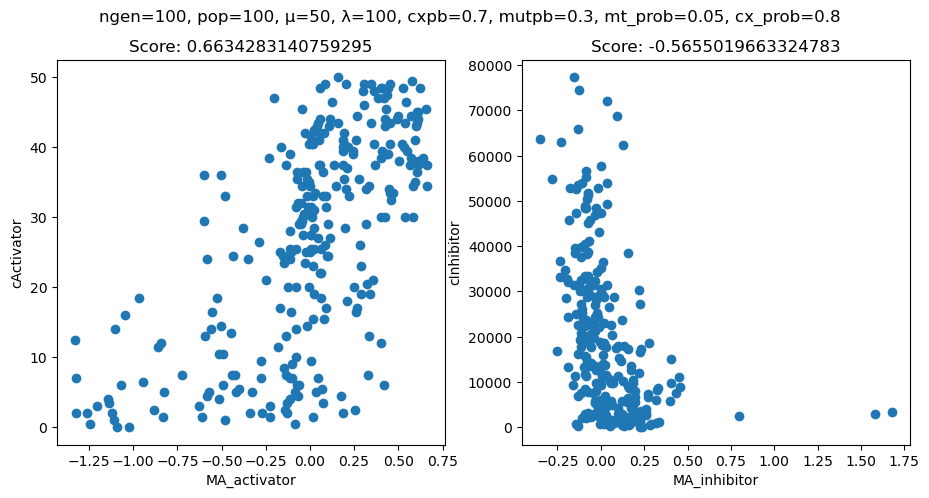

In [129]:
# plot and save results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), squeeze= True)
title = 'ngen='+str(ngen)+', pop='+str(nind)+', μ='+str(mu)+', λ='+str(lambda_)+', cxpb='+str(cxpb)+', mutpb='+str(mutpb)+', mt_prob='+str(mt_prob)+', cx_prob='+str(cx_prob)
fig.suptitle(title)
ax1.set_xlabel('MA_activator')
ax2.set_xlabel('MA_inhibitor')
ax1.set_ylabel('cActivator')
ax2.set_ylabel('cInhibitor')

eval_act, eval_inh = toolbox.evaluate(hof[0])
ax1.set_title('Score: '+str(eval_act))
ax2.set_title('Score: '+str(eval_inh))

gene_saving = input_parameters['gene_of_interest']
if solve == 'cInhibitor':
    # If cActivator is used to calculate cInhibitor
    ax1.scatter(MA_df.iloc[:,0], hof[0][:,0])
    saved_cActivators[gene_saving] = hof[0][:,0]
    ax2.scatter(MA_df.iloc[:,1], hof[0][:,1])
    saved_cInhibitors[gene_saving] = hof[0][:,1]
else: 
    # If cInhibitor is used to calculate cActivator
    ax1.scatter(MA_df.iloc[:,0], hof[0][:,1])
    saved_cActivators[gene_saving] = hof[0][:,1]
    ax2.scatter(MA_df.iloc[:,1], hof[0][:,0])
    saved_cInhibitors[gene_saving] = hof[0][:,0]
    
saved_cActivators.to_pickle('../data/saved_cActivator_vals.pkl')
saved_cInhibitors.to_pickle('../data/saved_cInhibitor_vals.pkl')


In [119]:
# convert this to a readable dataframe
values_df['cActivator'] = hof[0][:, 0]
values_df['cInhibitor'] = hof[0][:, 1]

In [131]:
# save csv versions
if True: # should only have to do once
    saved_cActivators = pd.read_pickle('../data/saved_cActivator_vals.pkl')
    saved_cInhibitors = pd.read_pickle('../data/saved_cInhibitor_vals.pkl')
    saved_cActivators.to_csv('../data/saved_cActivator_vals.csv')
    saved_cInhibitors.to_csv('../data/saved_cInhibitor_vals.csv')
    
    # save of TF concentrations of baseline values
    # for now, it's just always crp
    # goofy, scaling to same range/units as are used in GAMs
    scaled_df = 10**log_tpm_df.loc['b3357']
    new = (scaled_df - min_val) / (max_val - min_val) * (10e-5 - 10e-9) + 10e-9
    new.to_csv('../data/exported_TF_conc.csv')

# plot predictions

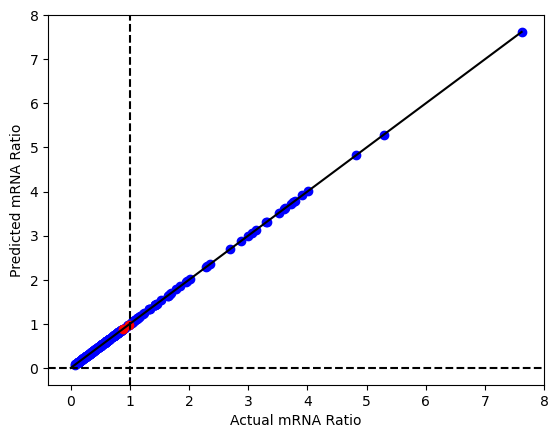

In [12]:
# predictions
# let's convert A matrix values to cActivator and cInhibitor values
# start with just plotting them against each other
#KdRNAPCrp = 2.5118864315095796e-07*3.5

# save our predictions
def calculate_z_scores(data):
    mean = statistics.mean(data)
    stdev = statistics.stdev(data)
    z_scores = [(x - mean) / stdev for x in data]
    return z_scores

preds_df = pd.DataFrame(index = values_df.index)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(values_df['cActivator'], values_df['cInhibitor'], RNAP = constant_vals['RNAP'], KdRNAP = constant_vals['KdRNAP'], KdRNAPCrp = constant_vals['KdRNAPCrp'], KeqOpening = constant_vals['KeqOpening'])
preds_df['predicted_mRNA_fold_change'] = predicted_mRNA
preds_df['predicted_log_tpm'] = np.log2(predicted_mRNA*2**(control_value_log_tpm))

#ratio = (2**(log_tpm_df.loc[gene][key]) / 2**(control_value_log_tpm))
#(2**(log_tpm_df.loc[gene][key]) = ratio * 2**(control_value_log_tpm))
#log_tpm_df.loc[gene][key] = np.log2(ratio*2**(control_value_log_tpm))


preds_df['actual_log_tpm'] = log_tpm_df.loc[gene][preds_df.index]
preds_df['difference'] = preds_df['predicted_log_tpm'] - preds_df['actual_log_tpm']
# I want a more complex way to add back in the bottom condition
preds_df.to_pickle('../data/saved_'+gene+'_predictions.pkl')



# plotting
unhighlighted = []
highlighted = []
for index in values_df.index:
    if index in basal_conditions:
        highlighted.append(index)
    else:
        unhighlighted.append(index)

        
# use these cActivator and cInhibitor values to calculate gene tpm and compare to known
predicted_mRNA = cActivator_cInhibitor_to_mRNA(values_df['cActivator'], values_df['cInhibitor'], RNAP = constant_vals['RNAP'], KdRNAP = constant_vals['KdRNAP'], KdRNAPCrp = constant_vals['KdRNAPCrp'], KeqOpening = constant_vals['KeqOpening'])
values_df['predicted_mRNA_ratio'] = predicted_mRNA
values_df['difference'] = values_df['predicted_mRNA_ratio'] - values_df['actual_mRNA_ratio']
predicted_mRNA = cActivator_cInhibitor_to_mRNA(values_df['cActivator'].loc[unhighlighted], values_df['cInhibitor'].loc[unhighlighted], RNAP = constant_vals['RNAP'], KdRNAP = constant_vals['KdRNAP'], KdRNAPCrp = constant_vals['KdRNAPCrp'], KeqOpening = constant_vals['KeqOpening'])
actual_mRNA = list(values_df.loc[unhighlighted].actual_mRNA_ratio)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'blue')

predicted_mRNA = cActivator_cInhibitor_to_mRNA(values_df['cActivator'].loc[highlighted], values_df['cInhibitor'].loc[highlighted], RNAP = constant_vals['RNAP'], KdRNAP = constant_vals['KdRNAP'], KdRNAPCrp = constant_vals['KdRNAPCrp'], KeqOpening = constant_vals['KeqOpening'])
actual_mRNA = list(values_df.loc[highlighted].actual_mRNA_ratio)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'red')

plt.xlabel('Actual mRNA Ratio')
plt.ylabel('Predicted mRNA Ratio')
plt.axvline(x = 1, color = 'k', linestyle = '--')
plt.axhline(y = 0, color = 'k', linestyle = '--')
#plt.axis('equal')
plt.plot([0, max(values_df.actual_mRNA_ratio)], [0, max(values_df.actual_mRNA_ratio)], color = 'k')
plt.show()

## 3D plot

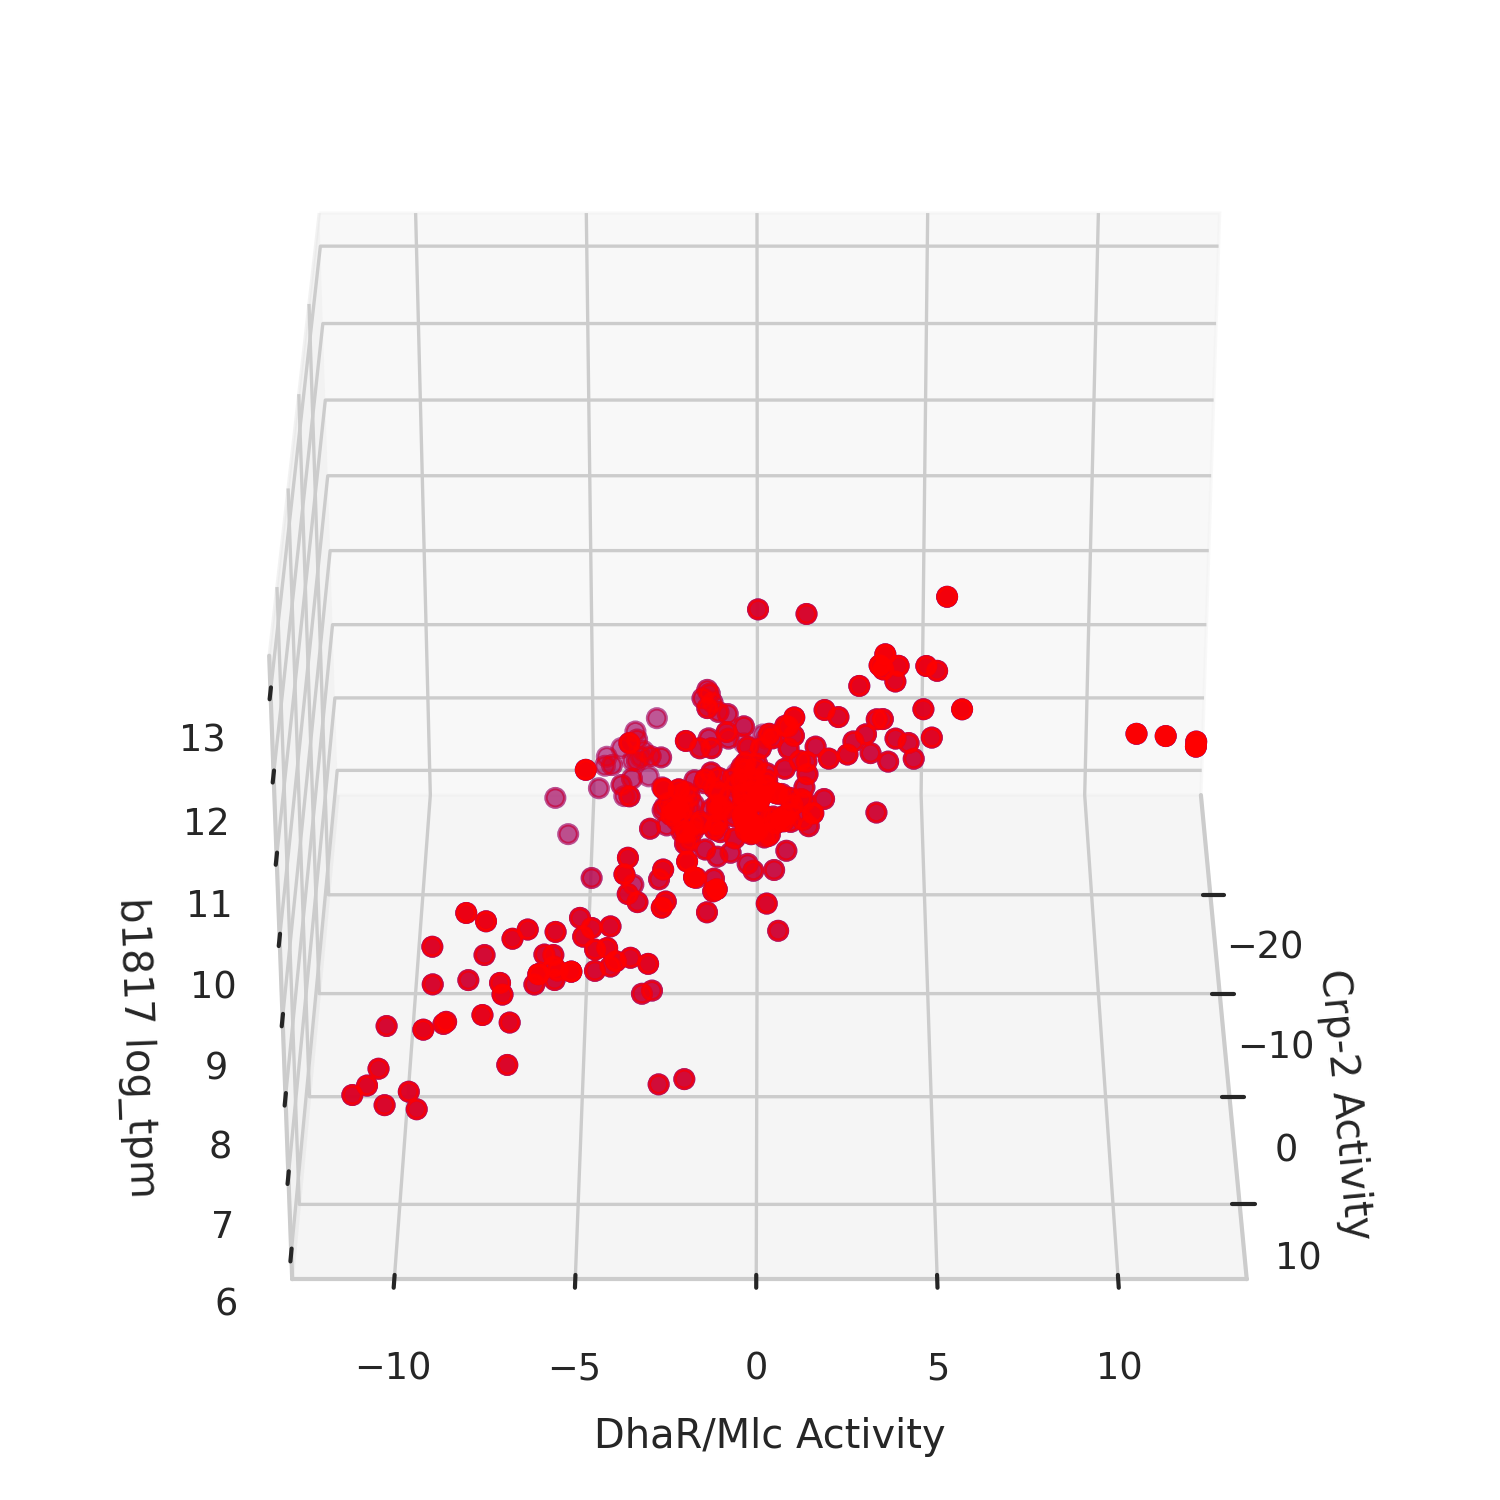

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

plt.rcParams["figure.dpi"] = 300
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set_palette("deep")
sns.set_context("paper")
sns.set_style("whitegrid")

# data_complete is a pandas dataframe
# with the x, y, z values and color for each point as cols
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(A_df.loc[iM_act], A_df.loc[iM_inh], preds_df['actual_log_tpm'], color = 'blue')
ax.scatter(A_df.loc[iM_act], A_df.loc[iM_inh], preds_df['predicted_log_tpm'], color = 'red')
ax.set_xlabel(iM_act+' Activity')
ax.set_ylabel(iM_inh+' Activity')
ax.set_zlabel(gene+' log_tpm')

# this function defines the animation action done to the plot
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('./densmap_complete.gif', writer=animation.PillowWriter(fps=10))